In [1]:
from fastai import *
from fastai.vision import *
from fastai.vision.all import *
from fastai.layers import *
from torchvision import transforms
import warnings
warnings.filterwarnings("ignore")

from fastai.distributed import *
from fastai.metrics import error_rate
from fastai.callback.tracker import SaveModelCallback

In [2]:
from torchvision import datasets, transforms, models
import torchvision.transforms as T

import torch.optim as optim
from torch.optim import lr_scheduler
import time
import os
import copy
import torch

from PIL import Image
import requests

import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn

In [3]:
from models.backbone import Backbone
from models.encoder import EncoderModule
from models.utils.joiner2 import *
from models.utils.losses import Attention_penalty_factor, Generator_loss, CriticLoss
from models.utils.metrics import Accuracy
from models.unet import UNet

In [4]:
H = 256
W= 256
bs=5

transform = T.Compose([
T.Resize((H,W)),
T.ToTensor(),
T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [5]:
#dataset = datasets.ImageNet(root='./data', transform=transform)

In [6]:
#print(len(dataset))

In [7]:
path = Path.home()/'Luiz/gan_attention/data'

transforms = ([*aug_transforms(),Normalize.from_stats([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

data = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files, 
                 splitter=RandomSplitter(),
                 get_y=parent_label,
                 item_tfms=Resize(H,W),
                 batch_tfms=transforms)

dld = data.dataloaders(path/'train',bs=bs) 

In [17]:
dld.train_ds
1024934+

(#1024934) [(PILImage mode=RGB size=450x300, TensorCategory(654)),(PILImage mode=RGB size=500x341, TensorCategory(467)),(PILImage mode=RGB size=356x500, TensorCategory(401)),(PILImage mode=RGB size=804x1058, TensorCategory(638)),(PILImage mode=RGB size=500x377, TensorCategory(532)),(PILImage mode=RGB size=540x256, TensorCategory(483)),(PILImage mode=RGB size=375x500, TensorCategory(866)),(PILImage mode=RGB size=500x333, TensorCategory(530)),(PILImage mode=RGB size=375x500, TensorCategory(225)),(PILImage mode=RGB size=500x400, TensorCategory(832))...]

In [7]:
train_size = 1081000
test_size = 200000
remainder = 167
train, valid, _ = torch.utils.data.random_split(dataset, [train_size, test_size, remainder])

In [8]:
#train_dl = DataLoader(train,bs=100)
#valid_dl = DataLoader(valid,bs=100)

In [9]:
train_dl = DataLoader(train,bs=10)
valid_dl = DataLoader(valid,bs=10)
dld = ImageDataLoaders(train_dl, valid_dl, device='cuda')

In [10]:
#train_dl = DataLoader(torch.utils.data.DataLoader(dataset.train, batch_size=100, shuffle=True)
#valid_dl = torch.utils.data.DataLoader(dataset.valid, batch_size=100, shuffle=True)

In [11]:
#dld = ImageDataLoaders(train_dl, valid_dl, device='cuda')

In [12]:
len(dld.train)

108100

In [13]:
model = Joiner(backbone = True, num_classes = 1000, bypass=False, hidden_dim=256, batch_size=10, image_h=H, image_w=W,grid_l=4,penalty_factor="2")

In [14]:
save = SaveModelCallback(monitor='Accuracy', fname='Encoder')

In [15]:
model_path = Path.home()/'Luiz/saved_models'
learn = Learner(dld, model, loss_func=CriticLoss(), metrics=[Accuracy], cbs=[save], model_dir=model_path)

SuggestedLRs(lr_min=1.9054607491852948e-07, lr_steep=1.3182567499825382e-06)

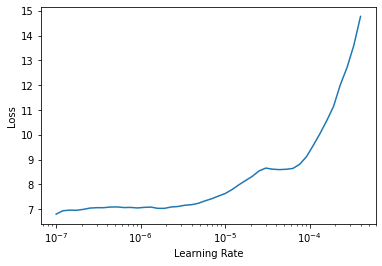

In [16]:
learn.lr_find()